In [1]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
import memory
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
from langchain_core.messages import AIMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, summarize_packets, execute_tools, save_iteration_node
from state import HoneypotStateReact
nest_asyncio.apply()


def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


# Memory implementation

In [3]:
def should_continue(state: HoneypotStateReact) -> Literal["tools", "threat_verification", "save_iteration", "cleanup", "__end__"]:
    """Determine next action based on the last message"""
    last_message = state.messages[-1]
    
    # If the last message has tool calls, execute them
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we need to summarize packet data
    if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
        return "threat_verification"

    # Before cleanup, save the iteration if we have analyzed data and final response
    if (len(state.packet_summary) > 1 and len(state.messages) > 1 and 
        not state.cleanup_flag and (not hasattr(last_message, 'tool_calls') or not last_message.tool_calls)):
        return "save_iteration"
    
    # After saving iteration, do cleanup
    if not state.cleanup_flag and len(state.messages) > 1 and len(state.packet_summary) > 1:
        return "cleanup"

    return "__end__"

In [4]:
def cleanup_messages(state: HoneypotStateReact):
    """Clean up ALL messages and data, keeping only essential state for next iteration"""
    print("Performing complete cleanup before ending iteration...")
    
    if state.messages:
        print("Flushing all messages and resetting state for next iteration")
        
        return {
            "messages": [],  # Flush all messages
            "packet_summary": {},  # Clear packet summary
            "network_flows": {},  # Clear network flows
            "security_events": {},  # Clear security events
            "compressed_packets": {},  # Clear compressed packets
            "firewall_config": [],  # Will be reloaded in next iteration
            "previous_iterations": [],  # Will be reloaded in next iteration
            "cleanup_flag": True
        }
    else:
        print("No messages to cleanup")
        return {}

In [5]:
def build_react_graph():
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("threat_verification", summarize_packets)
    builder.add_node("save_iteration", save_iteration_node)  # NEW: Save iteration node
    builder.add_node("cleanup", cleanup_messages)  # Modified cleanup
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue)
    builder.add_edge("tools", "assistant")
    builder.add_edge("threat_verification", "assistant")
    builder.add_edge("save_iteration", "cleanup")  # NEW: Save iteration then cleanup
    builder.add_edge("cleanup", "__end__")  # Cleanup then end
        
    return builder.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:55343/devtools/browser/0e0d9d69-048b-463d-9eeb-a883b52ba630
INFO:pyppeteer.launcher:terminate chrome process...


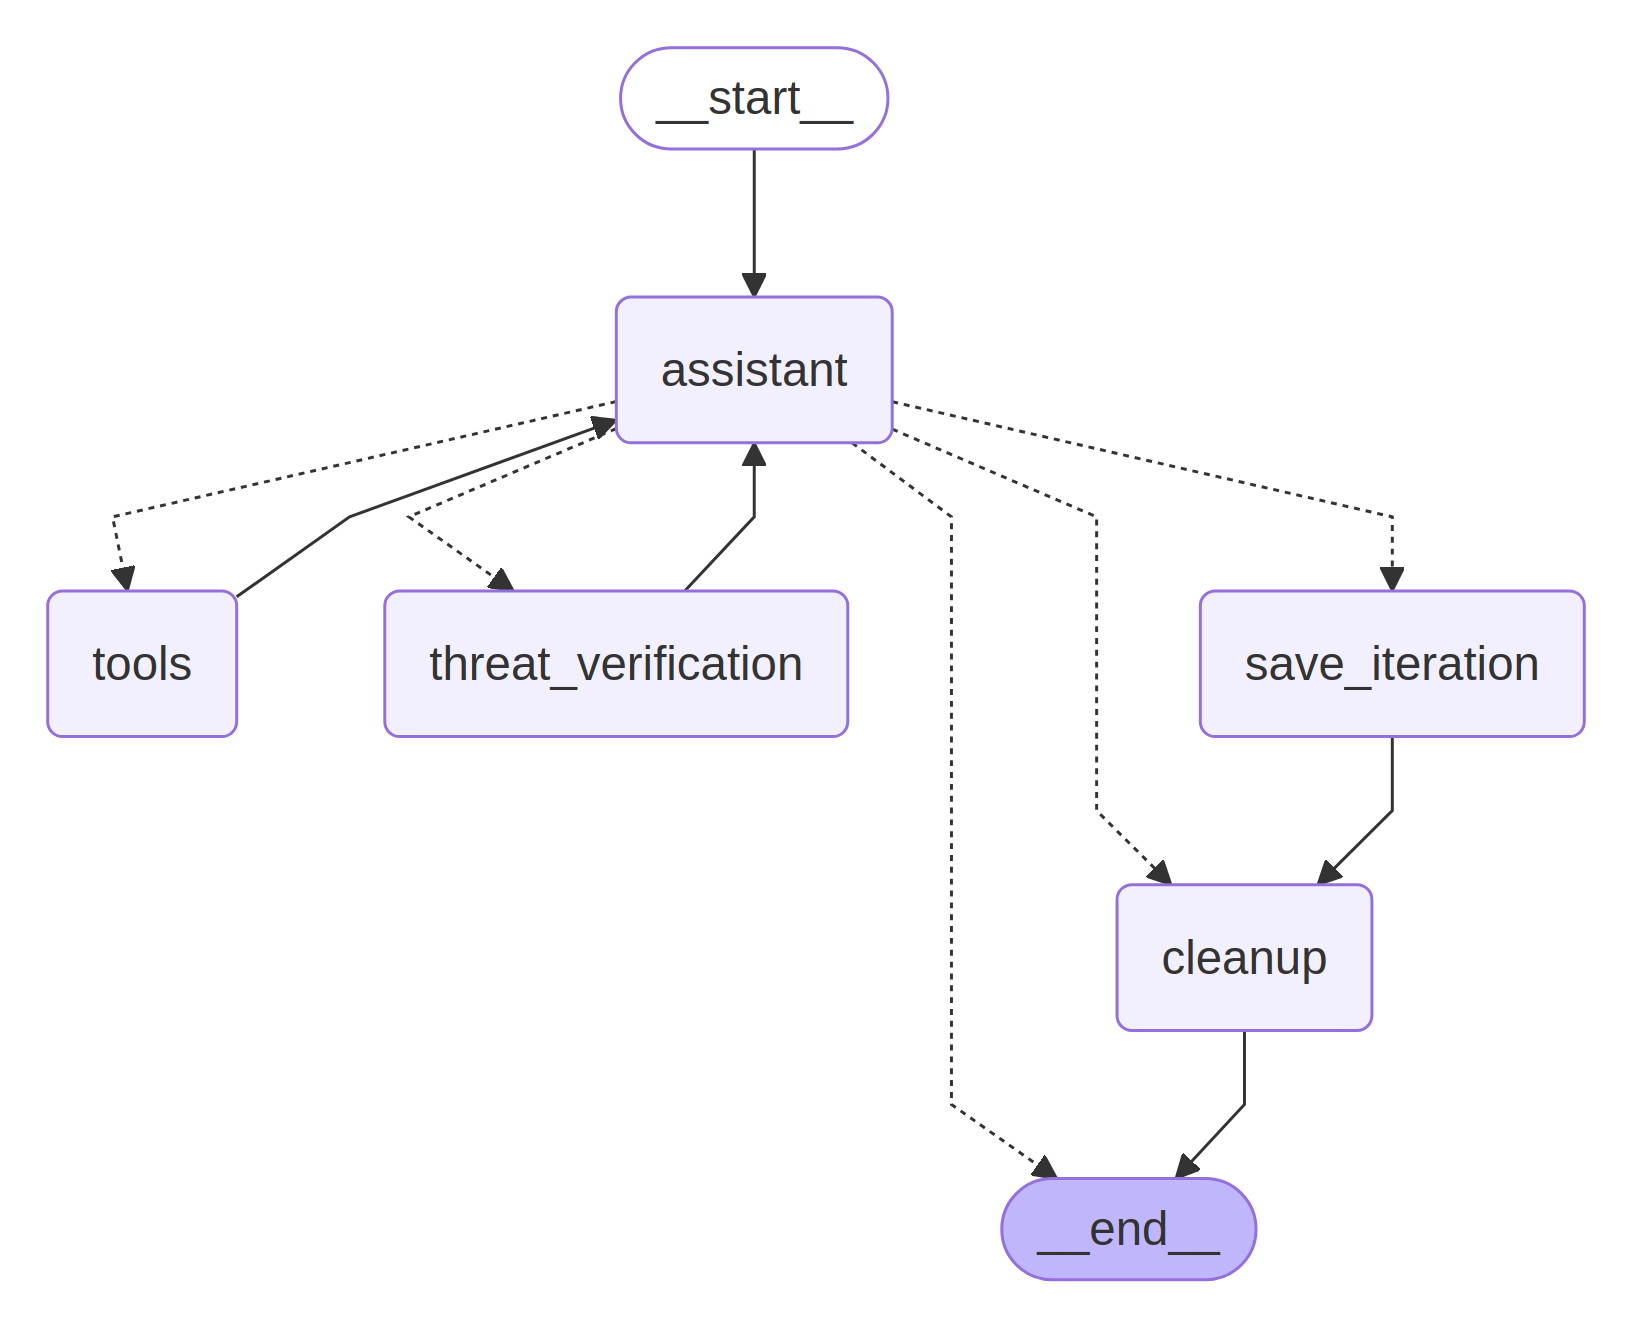

In [24]:
graph = build_react_graph()
display_graph(graph)

In [31]:
# Create an initial state
initial_state = HoneypotStateReact(
    messages="Analyze a time_window=2 for all the tools"
)
response = graph.invoke(initial_state)

Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving services status
INFO:tools:Retrieving security events (window: 2 minutes)
INFO:tools:Retrieving network flows (window: 2 minutes)
INFO:tools:Retrieving compressed packets (limit: 500, window: 2)
INFO:tools:Retrieving firewall rules...
INFO:tools:Retrieved 40 flows with 3 threat IPs
INFO:tools:Threat details found for IPs: ['192.168.100.1', '192.168.100.2', '192.168.100.254']
INFO:tools:Successfully retrieved firewall rules
INFO:tools:Retrieved 3 threat IPs, 0 command executions, 0 total threats
INFO:tools:Successfully retrieve services health
INFO:tools:Retrieved 416 compressed packets, 12 with threats, 0 with command execution
INFO:nodes:Network flows: Found threats from 3 IPs with details: ['192.168.100.1', '192.168.100.2', '192.168.100.254']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Extracted 3 threat incidents w

Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding block rule: 192.168.100.254 -> 192.168.100.1:5000
INFO:tools:Adding block rule: 192.168.100.254 -> 192.168.100.1:6000
INFO:tools:Removing firewall rule #5
INFO:tools:Successfully added block rule
INFO:tools:Successfully added block rule
INFO:tools:Successfully removed rule #5
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Memory: Iteration saved with ID iteration_4. Total iterations: 4
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


In [32]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze a time_window=2 for all the tools
================================== Ai Message ==================================
Tool Calls:
  check_services_health (call_J4v76n1Jak6a9mE666dKGOgf)
 Call ID: call_J4v76n1Jak6a9mE666dKGOgf
  Args:
  get_security_events (call_Q3ogwp7JJUQdHImX8upYy5iy)
 Call ID: call_Q3ogwp7JJUQdHImX8upYy5iy
  Args:
    time_window: 2
  get_network_flows (call_3JSEVdANT6oL4wikCw1yLAdP)
 Call ID: call_3JSEVdANT6oL4wikCw1yLAdP
  Args:
    time_window: 2
  get_compressed_packets (call_c6Ara25RtvKWmO0Z6wbOEXDt)
 Call ID: call_c6Ara25RtvKWmO0Z6wbOEXDt
  Args:
    time_window: 2
  get_firewall_rules (call_J3tROuwDQ6khsd6WLRvpkeOj)
 Call ID: call_J3tROuwDQ6khsd6WLRvpkeOj
  Args:
  getDockerContainers (call_qjLCGcIUNR0MGVnvay5zYRmq)
 Call ID: call_qjLCGcIUNR0MGVnvay5zYRmq
  Args:
================================= Tool Message =================================
Name: check_services_health

{"